In [1]:
!wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv
!wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_test.csv

--2021-03-23 14:18:01--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460676 (450K) [text/plain]
Saving to: 'house_prices_train.csv.1'

house_prices_train. 100%[===================>] 449.88K  1.52MB/s    in 0.3s    

2021-03-23 14:18:02 (1.52 MB/s) - 'house_prices_train.csv.1' saved [460676/460676]

--2021-03-23 14:18:02--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
H

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib. pyplot as plt
import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np

sns.set(style='whitegrid', context='notebook')

In [3]:
data = pd.read_csv('house_prices_train.csv')
test = pd.read_csv('house_prices_test.csv')

In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
data.shape

(1460, 81)

In [6]:
[print(f"{str(td).split()[1]} => {data.select_dtypes(td).shape[1]}") for td in (object, int, float)];

'object'> => 43
'int'> => 35
'float'> => 3


In [7]:
drop_categorical_column = ['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [8]:
data.drop(drop_categorical_column, axis=1, inplace=True)

In [9]:
data.select_dtypes(exclude=["number","bool_",]).isna().sum()

MSZoning           0
Street             0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         8
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Heating            0
HeatingQC          0
CentralAir         0
Electrical         1
KitchenQual        0
Functional         0
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PavedDrive         0
SaleType           0
SaleCondition      0
dtype: int64

In [10]:
categorical = pd.get_dummies(data.select_dtypes(exclude=["number","bool_",]))

In [11]:
int_float = data.select_dtypes(exclude=['object_'])

In [12]:
pd.concat([categorical, data[['SalePrice']]], axis=1).corr()[['SalePrice']]

,SalePrice
MSZoning_C (all),-0.111257
MSZoning_FV,0.089950
MSZoning_RH,-0.065429
MSZoning_RL,0.245063
MSZoning_RM,-0.288065
...,...
SaleCondition_Alloca,-0.015525
SaleCondition_Family,-0.046480
SaleCondition_Normal,-0.153990
SaleCondition_Partial,0.352060


In [13]:
best_features = pd.concat([categorical, data[['SalePrice']]], axis=1).corr()[['SalePrice']].apply(abs).sort_values('SalePrice')

In [14]:
best_features = best_features.reset_index()

In [15]:
best_features.rename(columns={'index' : "Faeatures",
                              'SalePrice' : 'Corr'}, inplace=True)

In [16]:
best_features

,Faeatures,Corr
0,BsmtFinType2_GLQ,0.000076
1,RoofMatl_Metal,0.000304
2,RoofStyle_Mansard,0.000308
3,GarageCond_Gd,0.000983
4,Foundation_Wood,0.002711
...,...,...
235,KitchenQual_Ex,0.504094
236,KitchenQual_TA,0.519298
237,BsmtQual_Ex,0.553105
238,ExterQual_TA,0.589044


In [17]:
best_features = best_features.where(best_features['Corr'] > 0.5, 0).query("Corr > 0.5")


In [18]:
best_features.Corr.values.T

array([0.50409368, 0.51929785, 0.55310485, 0.58904352, 1.        ])

In [19]:
cat_data = pd.concat([categorical, data[['SalePrice']]], axis=1)[best_features.Faeatures]

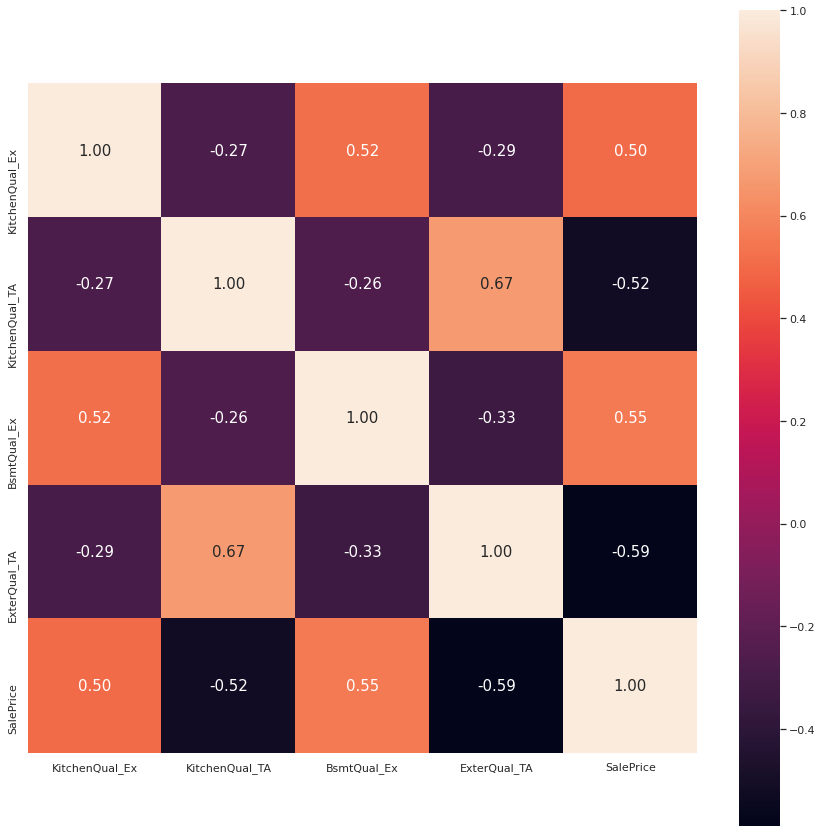

In [20]:
cm = np.corrcoef(cat_data.values.T)
sns.set(font_scale=1.5)
sns.set(rc={'figure.figsize' : (15, 15)})
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.02f', annot_kws={'size':15}, yticklabels=cat_data.columns, xticklabels=cat_data.columns)
plt.show()

In [21]:
categorical_variables = cat_data[['ExterQual_TA','BsmtQual_Ex', 'SalePrice' ]]

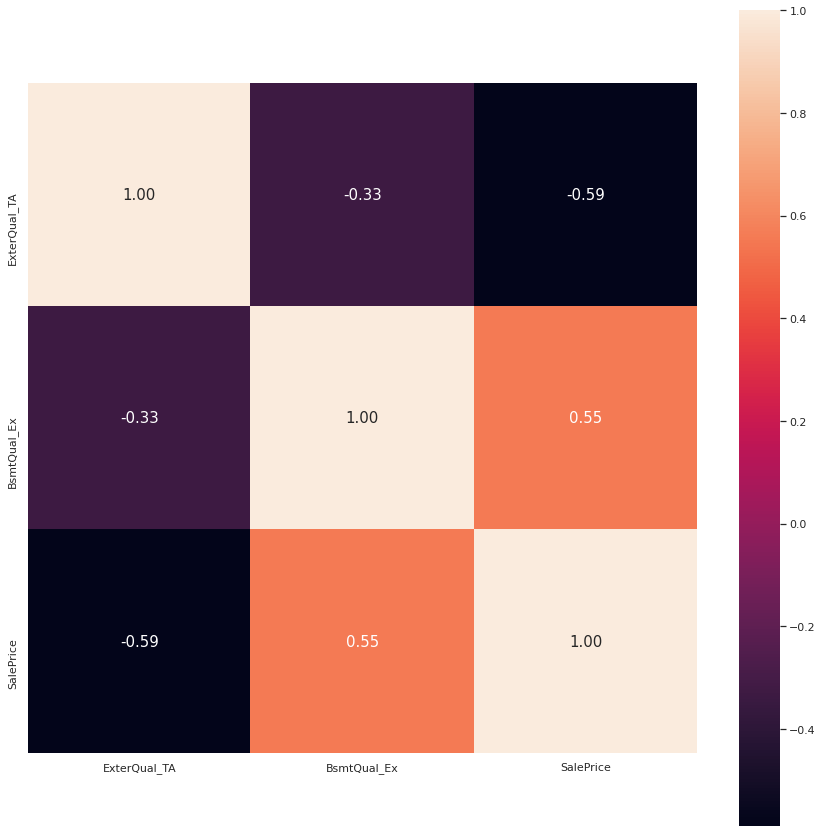

In [22]:
cm = np.corrcoef(categorical_variables.values.T)
sns.set(font_scale=1.5)
sns.set(rc={'figure.figsize' : (15, 15)})
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.02f', annot_kws={'size':15}, yticklabels=categorical_variables.columns, xticklabels=categorical_variables.columns)
plt.show()

In [23]:
categorical_variables.corr()

,ExterQual_TA,BsmtQual_Ex,SalePrice
ExterQual_TA,1.000000,-0.333227,-0.589044
BsmtQual_Ex,-0.333227,1.000000,0.553105
SalePrice,-0.589044,0.553105,1.000000


In [24]:
categorical_variables = categorical_variables.drop('SalePrice', axis=1)

In [25]:
numeric_variable = data.select_dtypes(exclude=['object_'])
numeric_variable = numeric_variable.drop('Id', axis=1)

In [26]:
numeric_corr = numeric_variable.corr()[['SalePrice']]
numeric_corr = numeric_corr.reset_index()
numeric_corr = numeric_corr.rename(columns={'index' : 'Features',
                             'SalePrice' : 'Corr'})
numeric_corr['Corr'] = numeric_corr['Corr'].apply(abs)

In [27]:
numeric_features = list(numeric_corr.query('Corr > 0.6').Features)

In [28]:
numeric_variable = numeric_variable[numeric_features]

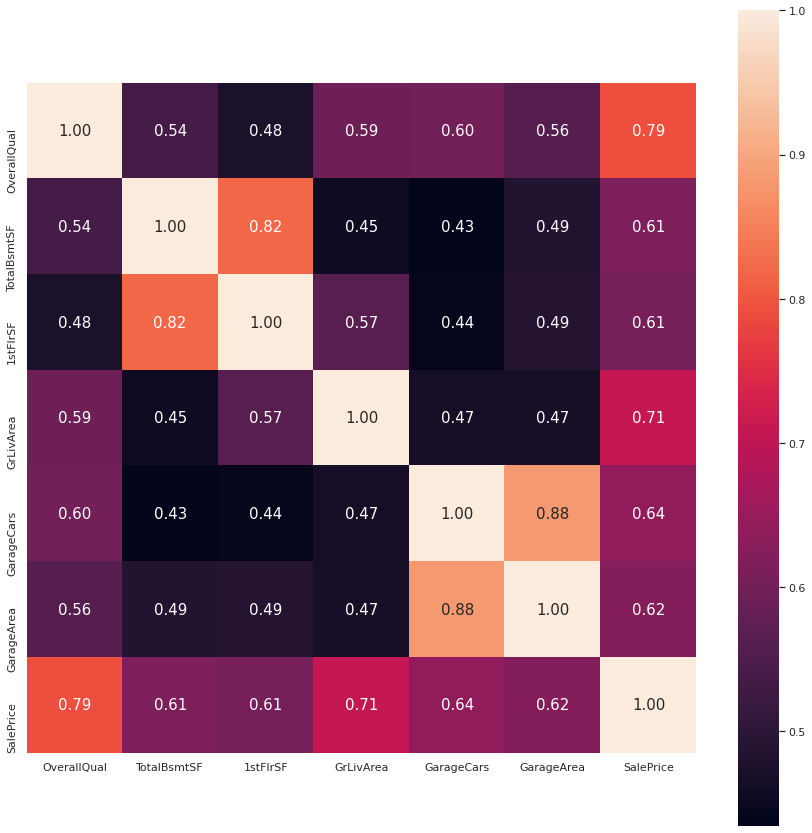

In [29]:
cm = np.corrcoef(numeric_variable.values.T)
sns.set(font_scale=1.5)
sns.set(rc={'figure.figsize' : (15, 15)})
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.02f', annot_kws={'size':15}, yticklabels=numeric_variable.columns, xticklabels=numeric_variable.columns)
plt.show()

In [30]:
list(numeric_variable.columns)

['OverallQual',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'SalePrice']

In [31]:
numeric_variables = numeric_variable[['GarageCars','GrLivArea', 'OverallQual', '1stFlrSF']]

In [32]:
numeric_variable# 'GrLivArea', 'OverallQual', 'TotalBsmtSF', 'FullBath',  'Fireplaces', 'GarageCars', '1stFlrSF', 'Fireplaces'

,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageCars,GarageArea,SalePrice
0,7,856,856,1710,2,548,208500
1,6,1262,1262,1262,2,460,181500
2,7,920,920,1786,2,608,223500
3,7,756,961,1717,3,642,140000
4,8,1145,1145,2198,3,836,250000
...,...,...,...,...,...,...,...
1455,6,953,953,1647,2,460,175000
1456,6,1542,2073,2073,2,500,210000
1457,7,1152,1188,2340,1,252,266500
1458,5,1078,1078,1078,1,240,142125


In [33]:
X_train  = pd.concat([numeric_variables, categorical_variables], axis=1)
X_train

,GarageCars,GrLivArea,OverallQual,1stFlrSF,ExterQual_TA,BsmtQual_Ex
0,2,1710,7,856,0,0
1,2,1262,6,1262,1,0
2,2,1786,7,920,0,0
3,3,1717,7,961,1,0
4,3,2198,8,1145,0,0
...,...,...,...,...,...,...
1455,2,1647,6,953,1,0
1456,2,2073,6,2073,1,0
1457,1,2340,7,1188,0,0
1458,1,1078,5,1078,1,0


In [34]:
X_train = pd.concat([X_train, data[['TotalBsmtSF', 'FullBath',  'Fireplaces']]], axis=1)

In [35]:
X_train.columns

Index(['GarageCars', 'GrLivArea', 'OverallQual', '1stFlrSF', 'ExterQual_TA',
       'BsmtQual_Ex', 'TotalBsmtSF', 'FullBath', 'Fireplaces'],
      dtype='object')

In [36]:
X_train

,GarageCars,GrLivArea,OverallQual,1stFlrSF,ExterQual_TA,BsmtQual_Ex,TotalBsmtSF,FullBath,Fireplaces
0,2,1710,7,856,0,0,856,2,0
1,2,1262,6,1262,1,0,1262,2,1
2,2,1786,7,920,0,0,920,2,1
3,3,1717,7,961,1,0,756,1,1
4,3,2198,8,1145,0,0,1145,2,1
...,...,...,...,...,...,...,...,...,...
1455,2,1647,6,953,1,0,953,2,1
1456,2,2073,6,2073,1,0,1542,2,2
1457,1,2340,7,1188,0,0,1152,2,2
1458,1,1078,5,1078,1,0,1078,1,0


In [37]:
test_categorical_variables = test.select_dtypes(exclude=['int_', 'float_'])
test_numerical_variables = test.select_dtypes(exclude=['object_'])

In [38]:
test_categorical_variables = pd.get_dummies(test_categorical_variables)[categorical_variables.columns]
test_numerical_variables = test_numerical_variables[numeric_variables.columns]

In [39]:
X_test = pd.concat([test_categorical_variables, test_numerical_variables], axis=1)

In [40]:
X_test.GarageCars.fillna(X_test.GarageCars.median(), inplace=True)

In [41]:
X_test = pd.concat([test[['TotalBsmtSF', 'FullBath', 'Fireplaces']], X_test], axis=1)
X_test.TotalBsmtSF.fillna(X_test.TotalBsmtSF.median(), inplace=True)
X_test.isna().sum()

TotalBsmtSF     0
FullBath        0
Fireplaces      0
ExterQual_TA    0
BsmtQual_Ex     0
GarageCars      0
GrLivArea       0
OverallQual     0
1stFlrSF        0
dtype: int64

In [42]:
quad = PolynomialFeatures(degree=2)
X_q_train = quad.fit_transform(X_train)
X_q_test = quad.fit_transform(X_test[X_train.columns])
y = np.log10(data.SalePrice)

In [43]:
slr = LinearRegression()
slr.fit(X_q_train, y)

LinearRegression()

In [44]:
np.sqrt(mean_squared_error(y, slr.predict(X_q_train)))

0.06636395051969578

In [45]:
pd.DataFrame({'Id': test.Id,
              'SalePrice' : 10 ** slr.predict(X_q_test)}).to_csv('EDA.csv', index=False)

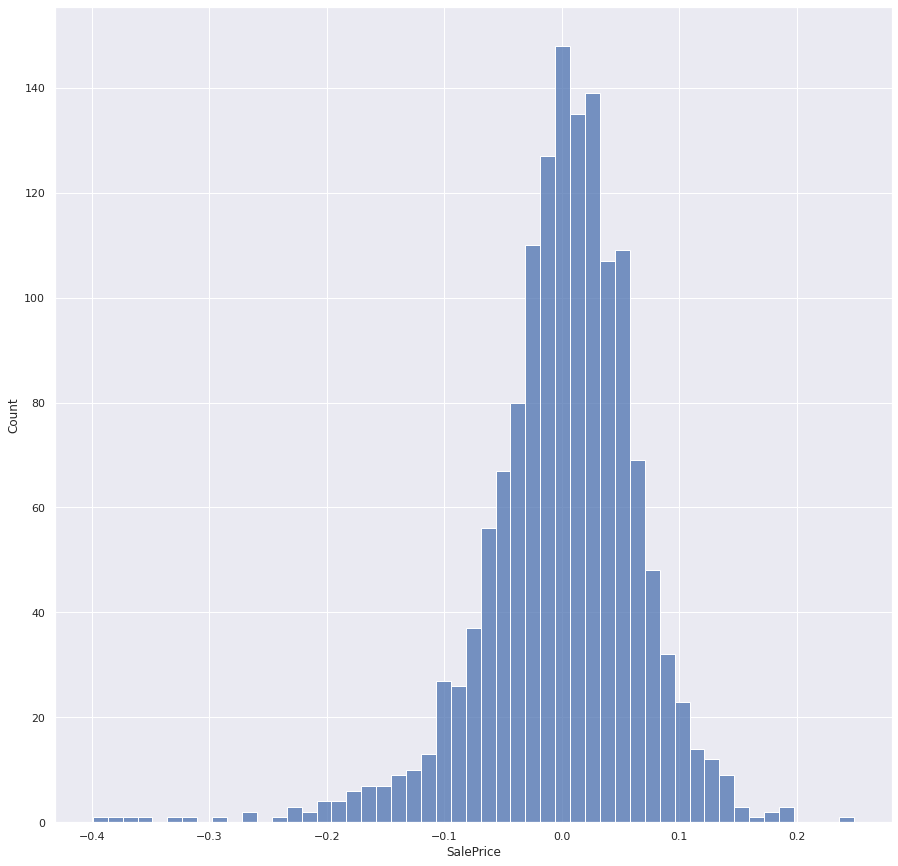

In [46]:
sns.histplot(y - slr.predict(X_q_train));